In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, ConcatDataset
from torchvision import transforms

# label为0-10，分别代表了下列标签：
label_names=['ambulance','apple','bear','bicycle','bird','bus','cat','foot','owl','pig']

# 图像大小为28*28，但是AlexNet网络输入为224*224，所以大小扩充成224
data_transforms = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Resize((224,224)), 
    # 单通道归一化                          
    transforms.Normalize((0.5,),(0.5,))])

# dataset类，方便datasetloader读取并输入模型中
class MyDataset(Dataset):
    def __init__(self, label_index, transform = data_transforms):
        path = "data/quick_draw_data/"+label_names[label_index]+"/"+label_names[label_index]+".npy" 
        self.data = np.load(path)
        self.labels = [label_index]*len(self.data)
        self.transform = transform
        
        # 显示前10个图像
#         plt.figure() # 新建画布，防止堆叠
#         for i in range(10):
#             plt.subplot(1,10,i+1)
#             data = self.data[i,:]
#             data = data.reshape( 28, 28)  #将数据转为（28，28）维度
#             img = Image.fromarray(data)  #转为图片
#             plt.imshow(img)
#             plt.title(label_names[label_index])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        image = Image.fromarray(data.reshape(28,28))  #将数据转为（28，28）维度
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

datasets = [MyDataset(label_index) for label_index in range(10)]
combined_dataset = ConcatDataset(datasets)  # 整的数据集

In [4]:
# 每类数据按照6:3:1方式划分训练集、验证集、测试集对模型进行训练
from torch.utils.data import random_split

# 定义划分比例
lengths = [int(len(combined_dataset)*0.6), int(len(combined_dataset)*0.3), int(len(combined_dataset)*0.1)]
# 划分数据集
train_set, val_set, test_set = random_split(combined_dataset, lengths)

# 构建CNN（例如Alex net）作为10-分类模型

Alexnet由八层网络构成，其中包括5层卷积层和3层全连接层。卷积层包含了卷积、激活、池化、局部归一化几个过程，全连接层包括了droupout、激活、全连接几个过程。

In [5]:
from torch import nn
from torch.nn import Sequential, Conv2d, ReLU, MaxPool2d, Linear, Dropout, Flatten

# 构建AlexNet网络变体作为分类器
class Net(nn.Module):
    def __init__(self,num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            # 特征提取层，padding填充
            # 输出大小 = ((输入大小 - 卷积核大小 + 2* padding) / 步长) + 1
            # 对网络的层数和参数数量进行了更改
            Conv2d(in_channels = 1, out_channels = 32, kernel_size = 4, stride = 2),  # (1*28*28) (32*13*13)
            ReLU(),
            MaxPool2d(3, 1),  # (32*11*11)
            
            Conv2d(32, 100, 3, 1),  # (100*9*9)
            ReLU(),
            MaxPool2d(3, 1),  # (100*7*7)
        )

        self.classifier = nn.Sequential(
            Flatten(),             # 展开成一维
            Linear(100*7*7, 2000),
            ReLU(),
            # 防止过拟合
            Dropout(0.5),
            Linear(2000, 2000),
            ReLU(),
            Dropout(0.5),
            Linear(2000, 10)
        )
        
    
    # 前向过程
    def forward(self,x):
        x = self.features(x)  # 特征提取
        x = self.classifier(x)  # 全连接+分类
        return x

# 训练模型
对模型进行训练，绘制训练过程中损失函数和预测acc曲线（在同一幅图中）

In [10]:
from torch.autograd import Variable
from torch.nn.functional import interpolate
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

# 训练过程
def model_train():
    model = Net()       # 创建模型
    batch_size = 32     # 批量训练大小
    epoch_num = 10
    learn_rate = 0.001 
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(),lr=learn_rate)

    # 数据加载器
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set,batch_size, shuffle=True)
    
    loss_set = []
    acc_set = []
    for i in range(epoch_num):
        # 训练模型
        print("epoch [%d]:" % (i+1))
        for j,(batch_data,batch_label) in enumerate(train_loader):
            output = model(batch_data)
            loss = loss_func(output, batch_label)
            # 优化器优化模型参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if ((j)%500 == 0):
                print("训练次数：{}，loss：{}".format(j, loss.item()))
        loss_set.append(loss.item())
        
        torch.save(model, "models/model_{}.pth".format(i))
        
        # 测试模型
        acc = 0
        with torch.no_grad():
            for j,(batch_data,batch_label) in enumerate(test_loader):
#                 batch_data = Variable(batch_data.view(32, 1, 28, 28)).to(torch.float32) # 通道数为1
                output = model(batch_data)
                acc += (output.argmax(1) == batch_label).sum()
            print("acc：{}".format(acc/len(test_set)))
            acc_set.append(acc/len(test_set))
    return model,loss_set,acc_set

In [11]:
model,loss_set,acc_set = model_train()

epoch [1]:
训练次数：0，loss：2.2988429069519043
训练次数：500，loss：0.49867430329322815
训练次数：1000，loss：0.9495379328727722
训练次数：1500，loss：1.0204116106033325
训练次数：2000，loss：0.8861054182052612
训练次数：2500，loss：0.3892476558685303
训练次数：3000，loss：0.582876980304718
训练次数：3500，loss：0.9625061750411987
acc：0.7614499926567078
epoch [2]:
训练次数：0，loss：0.6823749542236328
训练次数：500，loss：0.6907235383987427
训练次数：1000，loss：0.28261691331863403
训练次数：1500，loss：0.8044219613075256
训练次数：2000，loss：0.5834684371948242
训练次数：2500，loss：0.37449440360069275
训练次数：3000，loss：0.7576044797897339
训练次数：3500，loss：0.4515499174594879
acc：0.7900999784469604
epoch [3]:
训练次数：0，loss：0.30881786346435547
训练次数：500，loss：0.5318390727043152
训练次数：1000，loss：0.5478968024253845
训练次数：1500，loss：0.6673238277435303
训练次数：2000，loss：0.8595349788665771
训练次数：2500，loss：0.7106937170028687
训练次数：3000，loss：0.6281262636184692
训练次数：3500，loss：0.6014768481254578
acc：0.7929499745368958
epoch [4]:
训练次数：0，loss：0.4900756776332855
训练次数：500，loss：0.5352036356925964
训练次数：1000，loss：0

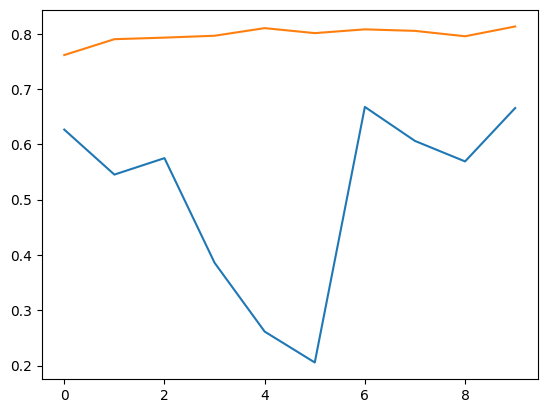

In [12]:
plt.plot(loss_set)
plt.plot(acc_set)
plt.show()

# 验证模型
从验证集中随机抽取10张图片进行预测，输出该图像的标签以及预测概率分布的柱状图

bird


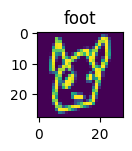

pig


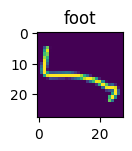

owl


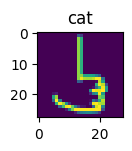

bus


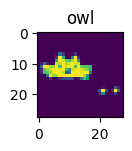

owl


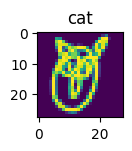

cat


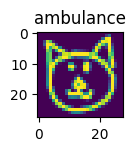

apple


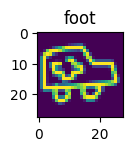

bus


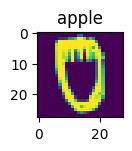

bicycle


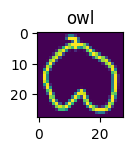

bear


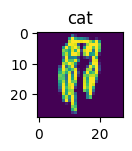

In [34]:
# 验证模型
label_names=['ambulance','apple','bear','bicycle','bird','bus','cat','foot','owl','pig']
for i in range(10):
    data = val_set[i][0]
    label = val_set[i][1]
    
    prediction = model(data.reshape(1,1,28,28))
    # torch.max返回张量指定维度上的最大值及索引
    index = torch.max(prediction.data, 1)[1]
    print(label_names[index])

#     plt.figure()
    plt.subplot(2,5,i+1)
    img = batch_data[i-1].reshape(28,28)
    plt.imshow(img)
    plt.title(label_names[batch_label[i]])
#     plt.bar(range(len(prediction.data)), prediction.data)
    plt.show()